# Exploratory Data Analysis Source Data

---

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Exploratory-Data-Analysis-Source-Data" data-toc-modified-id="Exploratory-Data-Analysis-Source-Data-1">Exploratory Data Analysis Source Data</a></span><ul class="toc-item"><li><span><a href="#US-Census-Counties" data-toc-modified-id="US-Census-Counties-1.1">US Census Counties</a></span></li><li><span><a href="#US-Energy-Information-Administration-(EIA)-Drilling-Productivity-Report" data-toc-modified-id="US-Energy-Information-Administration-(EIA)-Drilling-Productivity-Report-1.2">US Energy Information Administration (EIA) Drilling Productivity Report</a></span><ul class="toc-item"><li><span><a href="#EIA-Basin-Drilling-Productivity-Report-Data" data-toc-modified-id="EIA-Basin-Drilling-Productivity-Report-Data-1.2.1">EIA Basin Drilling Productivity Report Data</a></span><ul class="toc-item"><li><span><a href="#EIA-Data-Dictionary" data-toc-modified-id="EIA-Data-Dictionary-1.2.1.1">EIA Data Dictionary</a></span></li></ul></li><li><span><a href="#EIA-Basin-Drilling-Productivity-Report-Data-as-Time-Series" data-toc-modified-id="EIA-Basin-Drilling-Productivity-Report-Data-as-Time-Series-1.2.2">EIA Basin Drilling Productivity Report Data as Time-Series</a></span></li></ul></li><li><span><a href="#Joining-EIA-Basin-Data-to-US-Census-Counties" data-toc-modified-id="Joining-EIA-Basin-Data-to-US-Census-Counties-1.3">Joining EIA Basin Data to US Census Counties</a></span></li><li><span><a href="#Nightfire-data" data-toc-modified-id="Nightfire-data-1.4">Nightfire data</a></span></li></ul></li></ul></div>

In [82]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2

In [55]:
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib.ticker as mtick
from matplotlib import dates # as mdates
# import matplotlib
from matplotlib.dates import DateFormatter
from pylab import imshow, show, get_cmap
import matplotlib.patches as mpatches

In [56]:
from capstone.etl.eia_retrieval import eia_retrieval
from capstone.etl.eia_parse import eia_parse_county, eia_parse_data
from capstone.etl.census_retrieval import census_retrieval
from capstone.etl.census_parse import parse_census
from capstone.etl.generate_basins import generate_us_basins
from tools.tools import get_current_time, read_json

In [57]:
config = read_json('../config.json')

current_date = get_current_time('yyyymmdd')

wd = f"{config['workspace_directory']}/data"

In [58]:
basin_colors_hex = {  # manually defined dictionary of EIA basin-level standardized colors 
    "Anadarko Region":    "#2BA2CF", 
    "Appalachia Region":  "#769F5D",
    "Bakken Region":      "#F6C432", 
    "Eagle Ford Region":  "#48366B", 
    "Haynesville Region": "#807B8F",
    "Niobrara Region":    "#9D3341",
    "Permian Region":     "#6F4B27",
}

In [59]:
plt.style.use('ggplot')

## US Census Counties

In order to plot US Energy Information Administration (EIA) Regions, US County shapes need to be obtained and plotted. The [US Census Bureau](https://www.census.gov/) publishes County Topologically Integrated Geographic Encoding and Referencing (TIGER) shapefiles that represent US County boundaries. 

* Shapefile link: https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/

In [60]:
census_shp = census_retrieval(f"{wd}/input/census")

census = gpd.read_file(census_shp)

census.columns = [c.lower() for c in census.columns]

census = census[
    (census['statefp'] != '66') & (census['statefp'] != '78') & (census['statefp'] != '69') & (census['statefp'] != '60') & (census['statefp'] != '02') & (census['statefp'] != '15') & (census['statefp'] != '72')
]  # drop alaska and hawaii and island territories for visualization

census = census.to_crs(epsg=5070)  # project to NAD83 / Conus Albers

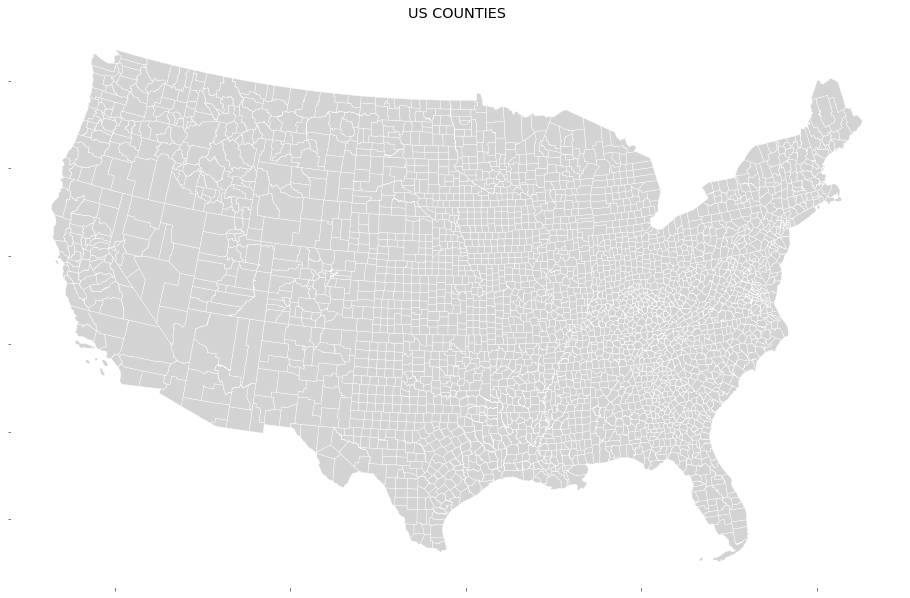

In [61]:
fig, ax = plt.subplots(figsize=(16, 16))

census.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.4)

plt.title('US COUNTIES')

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

ax.set_facecolor('white')

plt.savefig(f'../images/us_counties.png', dpi=300)
plt.show();

## US Energy Information Administration (EIA) Drilling Productivity Report
The US Energy Information Administration (EIA) publishes a [monthly Drilling Productivity Report](https://www.eia.gov/petroleum/drilling/).  The report includes tabs for each basin, with data from 2007 to the latest completed month. In addition it includes a list of County Geographic Identifiers that can be **joined to the US Census County** shapefile data to delineate the County-derived basin region boundaries.

In [62]:
eia_xls = eia_retrieval(f"{wd}/input/eia")
eia_cnty = eia_parse_county(eia_xls)
eia_data = eia_parse_data(eia_xls)  # parse the target variable(s) data

 parse eia data
    for Anadarko Region
    for Appalachia Region
    for Bakken Region
    for Eagle Ford Region
    for Haynesville Region
    for Niobrara Region
    for Permian Region


There are two files I parse from this excel. 

* `eia_cnty` - which is the Basin Region names along with US Census Geographic Identifiers needed to match to US Census County shapefile
* `eia_data` - the data about the Basin Region productivity.

### EIA Basin Drilling Productivity Report Data

In [63]:
eia_data.head(5)  # this is the production data for each basin by month since 2007

,month,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,region,rig_count
0,2007-01-01,-112112.15,840.713208,4031234.67,-370.40457,19.309806,126398.038,Anadarko Region,176.0
1,2007-02-01,-115386.99,847.042307,4053324.71,-723.02653,20.184060,134177.221,Anadarko Region,180.0
2,2007-03-01,-118312.94,851.808491,4165395.70,-1036.83450,20.970401,137515.513,Anadarko Region,166.0
3,2007-04-01,-121511.37,855.978981,4121693.16,-1379.90980,21.841327,141655.169,Anadarko Region,157.0
4,2007-05-01,-124585.07,859.249200,4201473.29,-1708.89630,22.694143,144415.586,Anadarko Region,170.0


#### EIA Data Dictionary

* **month** 
    * Year - Month
* **region**
    * Basin Region
* **rig_count**
    * Count Rigs in Basin
* **natgas_mcf_d_legacy_production_change** 
    * Natural gas (Mcf/d) Legacy production change
* **natgas_mcf_d_production_per_rig** 
    * Natural gas (Mcf/d) Production per rig
* **natgas_mcf_d_total_production** 
    * Natural gas (Mcf/d) Total production
* **oil_bbl_d_legacy_production_change**
    * Oil (bbl/d) Legacy production change
* **oil_bbl_d_production_per_rig**
    * Oil (bbl/d) Production per rig
* **oil_bbl_d_total_production**
    * Oil (bbl/d) Total production


In [64]:
eia_data[['region', 'oil_bbl_d_total_production']].head(7)  # Will be using oil_bbl_d_total_production as target col.

,region,oil_bbl_d_total_production
0,Anadarko Region,126398.038
1,Anadarko Region,134177.221
2,Anadarko Region,137515.513
3,Anadarko Region,141655.169
4,Anadarko Region,144415.586
5,Anadarko Region,137841.311
6,Anadarko Region,139381.847


In [65]:
eia_data.dtypes  # the data dtypes of the input data after parsing 

month                                    datetime64[ns]
natgas_mcf_d_legacy_production_change           float64
natgas_mcf_d_production_per_rig                 float64
natgas_mcf_d_total_production                   float64
oil_bbl_d_legacy_production_change              float64
oil_bbl_d_production_per_rig                    float64
oil_bbl_d_total_production                      float64
region                                           object
rig_count                                       float64
dtype: object

In [66]:
eia_data.describe()  # descriptive statistics

,natgas_mcf_d_legacy_production_change,natgas_mcf_d_production_per_rig,natgas_mcf_d_total_production,oil_bbl_d_legacy_production_change,oil_bbl_d_production_per_rig,oil_bbl_d_total_production,rig_count
count,1113.000000,1113.000000,1.113000e+03,1113.000000,1113.000000,1.113000e+03,1099.000000
mean,-212149.221062,3015.019143,6.228038e+06,-34171.863542,333.005350,6.011631e+05,140.606915
std,190971.732878,3750.247774,5.757697e+06,47924.001884,416.978172,7.742754e+05,115.153229
min,-997642.260000,77.526847,1.861918e+05,-288983.150000,2.988818,2.400000e+04,16.000000
25%,-292438.000000,954.016977,3.645695e+06,-48592.199000,33.047552,6.500000e+04,56.000000
50%,-152354.960000,1472.449060,4.771623e+06,-14363.063000,131.034944,2.781470e+05,99.000000
75%,-95728.486000,4022.562710,6.790772e+06,-2011.937500,459.616311,9.310919e+05,189.500000
max,-1787.853800,18828.672900,3.384569e+07,-280.865740,1904.260130,4.854688e+06,565.000000


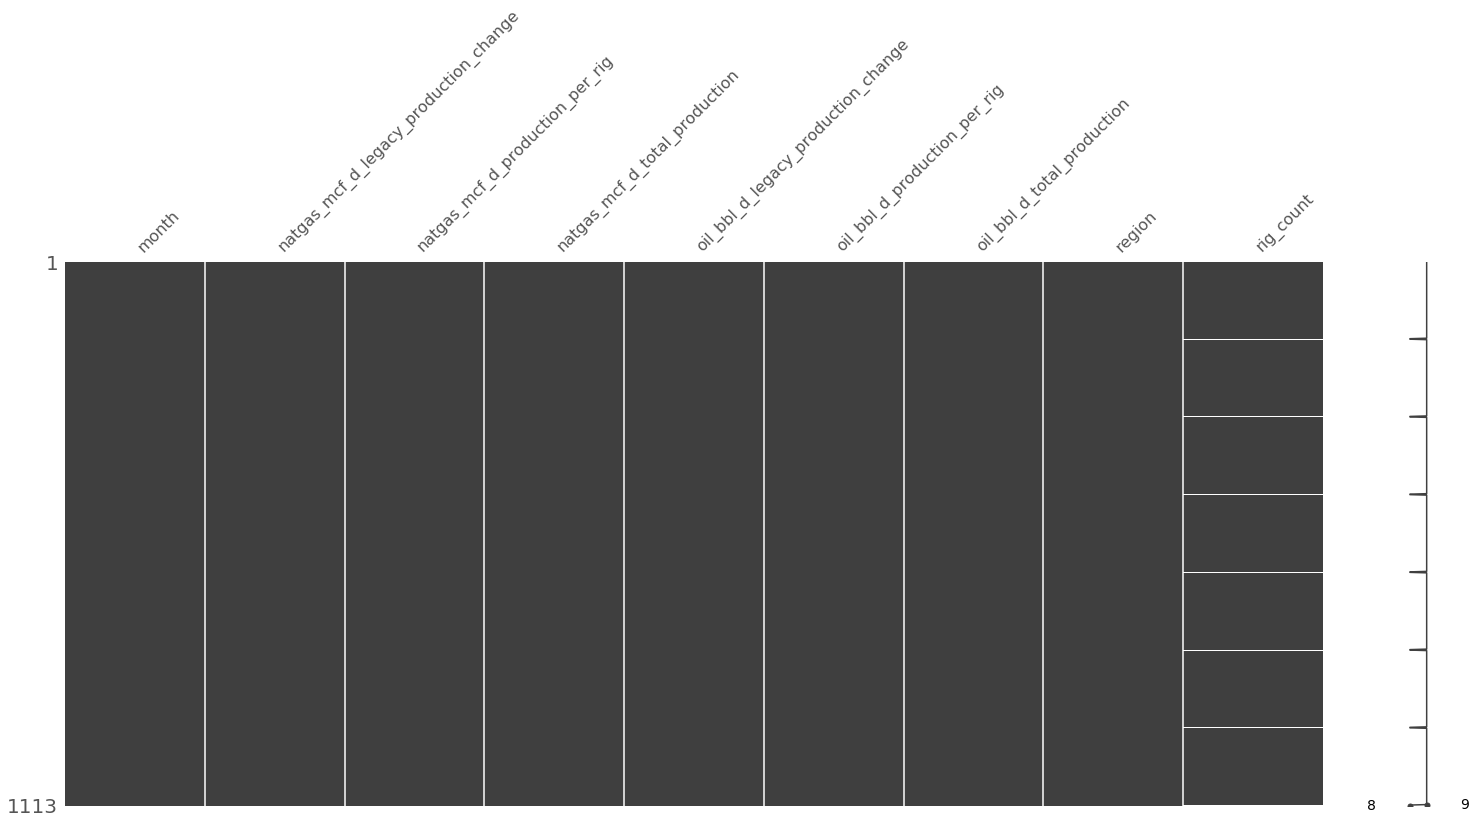

In [67]:
msno.matrix(eia_data);  # check for missing data, looks good as this is a report, not raw data.

In [68]:
eia_data['colors'] = eia_data['region'].map(basin_colors_hex)  # adding custom colors column for plots

In [69]:
eia_data.set_index('month', inplace=True)
eia_data.sort_index(inplace=True)  # sort by datetime just to be safe

In [70]:
# code to plot each of the 

def eia_variable_plot(var, legend_loc=2):
    fig, ax = plt.subplots(1, 1, figsize=(16, 6))

    region_list = list(eia_data['region'].unique())
    region_list.sort()

    for region in region_list:
        df = eia_data[eia_data['region'] == region][['region', var, 'colors']]
        df.plot(
            label=region,
            legend=True,
            ax=ax,
            color=df['colors'],
            linewidth=3.5, 
        )

    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    ax.yaxis.set_minor_formatter(tick) 

    ax.set_ylabel(var.replace('_', ' ').upper())
    ax.set_xlabel("MONTHLY EIA REPORTS")
    
    plt.legend(
        title='REGIONS', 
        loc=legend_loc, 
        shadow=True, 
        facecolor='white', 
        labels=region_list,
    )
    plt.title(var.replace('_', ' ').upper())
    
    plt.savefig(f'../images/eia_report_{var}.png', dpi=300)
    plt.show();

### EIA Basin Drilling Productivity Report Data as Time-Series

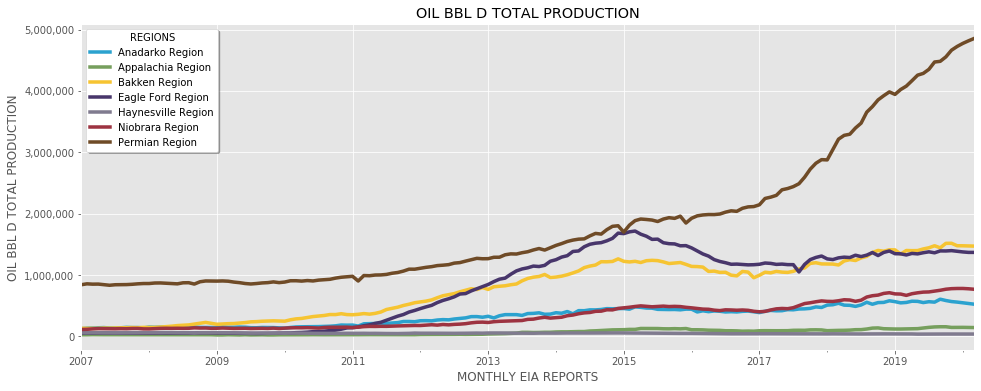

In [71]:
var = 'oil_bbl_d_total_production'
eia_variable_plot(var)

**Oil (bbl/d) Total production** per Basin Region per Month will is the target variable.

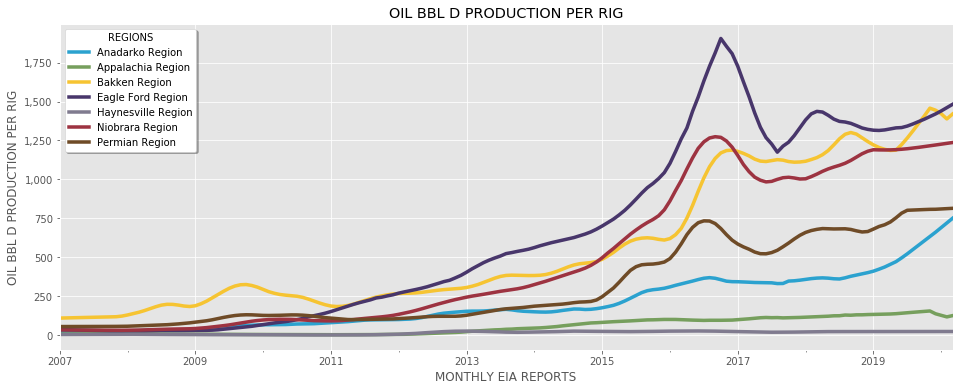

In [72]:
var = 'oil_bbl_d_production_per_rig'
eia_variable_plot(var)

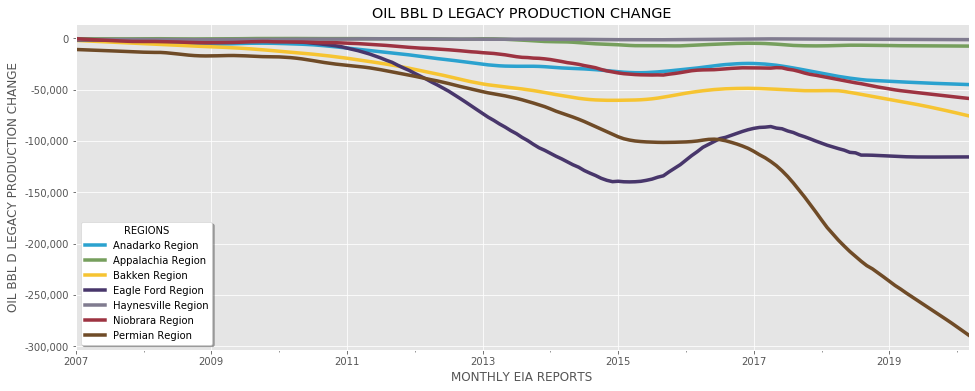

In [73]:
var = 'oil_bbl_d_legacy_production_change'
eia_variable_plot(var, legend_loc=3)

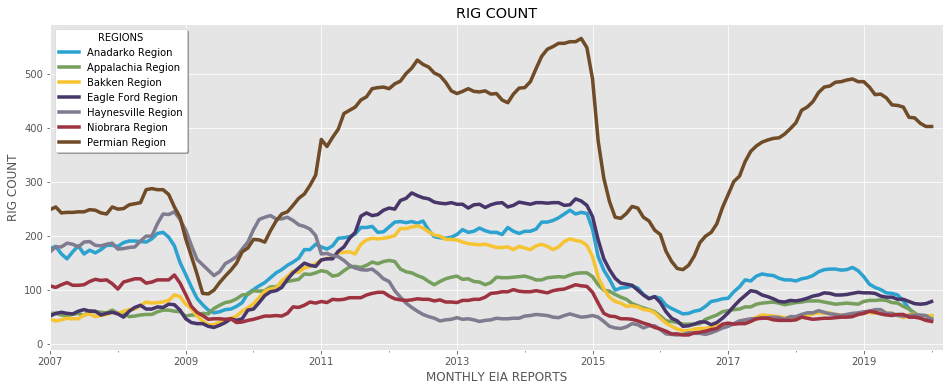

In [74]:
var = 'rig_count'
eia_variable_plot(var)

The EIA published a report ["Rethinking rig count as a predictor of natural gas production."](https://www.eia.gov/todayinenergy/detail.php?id=13551) However, extraction technology changed so this is no longer as reliable. 

![](https://www.eia.gov/todayinenergy/images/2013.10.28/rigcount.png)

_<center>[Rethinking rig count as a predictor of natural gas production - EIA](https://www.eia.gov/todayinenergy/detail.php?id=13551)</center>_

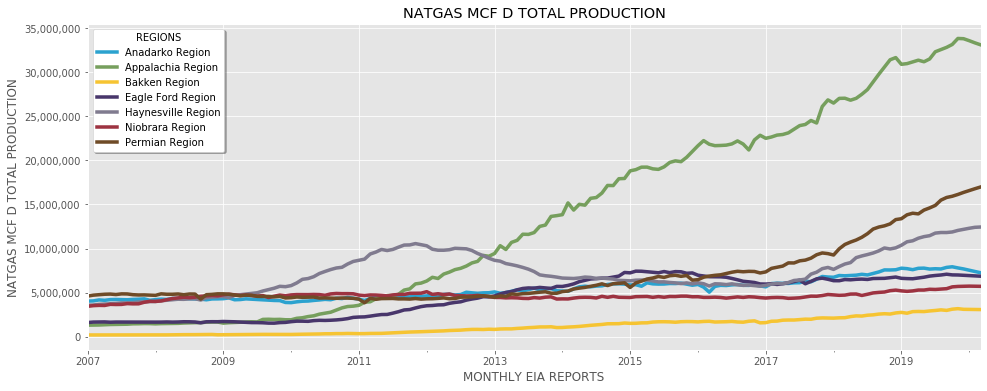

In [75]:
var = 'natgas_mcf_d_total_production'
eia_variable_plot(var)

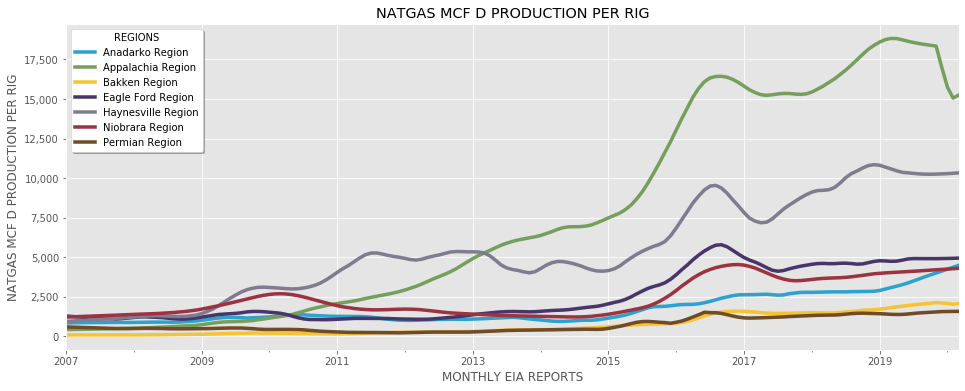

In [76]:
var = 'natgas_mcf_d_production_per_rig'
eia_variable_plot(var)

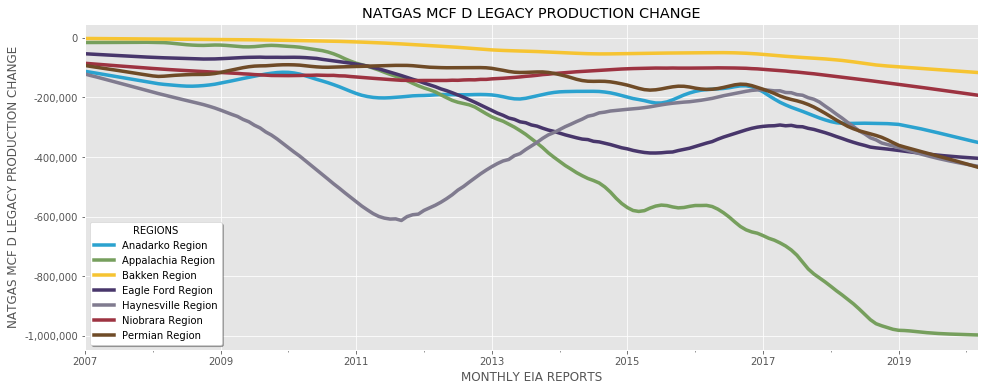

In [77]:
var = 'natgas_mcf_d_legacy_production_change'
eia_variable_plot(var, legend_loc=3)

## Joining EIA Basin Data to US Census Counties

In [78]:
census_gdf = parse_census(census_shp)
basins_list, all_basins = generate_us_basins(
    census_gdf,
    eia_cnty,
    f"{wd}/input/basins",
)  # this code creates individual files for basin geographies as well as an all_basins geography file/object.

generating us basins
    permian region
    appalachia region
    haynesville region
    eagle ford region
    anadarko region
    niobrara region
    bakken region


In [79]:
all_basins['colors'] = all_basins['region'].map(basin_colors_hex)

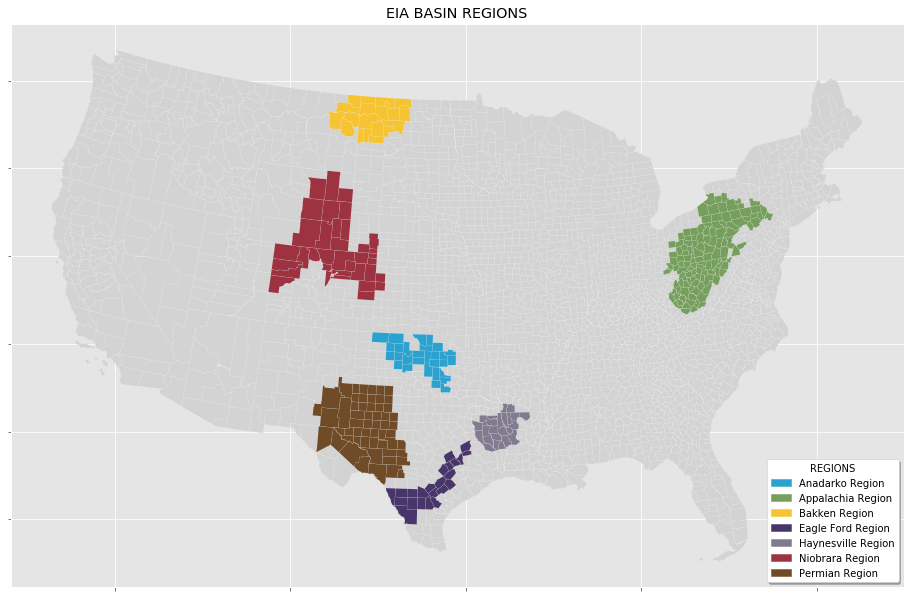

In [80]:
fig, ax = plt.subplots(figsize=(16, 16))

all_basins = all_basins.to_crs(epsg=5070)  # NAD83 / Conus Albers

census.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.1, alpha=0.99)

region_list = list(all_basins['region'].unique())
region_list.sort()

legend_patches = []

for region in region_list:
    df = all_basins[all_basins['region'] == region][['region', 'colors', 'geometry']]

    df.plot(
        ax=ax, 
        label=region,
        legend=True,
        color=basin_colors_hex[region], 
        edgecolor='white', 
        linewidth=0.1, 
    )
    
    legend_patches.append(mpatches.Patch(color=basin_colors_hex[region], label=region))

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])

plt.legend(
    title='REGIONS', 
    loc=4, 
    shadow=True, 
    facecolor='white', 
    labels=region_list,
    handles=legend_patches
)

plt.title('EIA BASIN REGIONS');
plt.savefig(f'../images/us_basins.png', dpi=300);

The seven basin regions in the map above are what the Nightfire data will be spatially joined to in the Geoprocessing section of this project (following notebook). 

## Nightfire data

> _The Earth Observation Group (EOG) specializes in nighttime observations of lights and combustion sources worldwide. The group started working with Defense Meteorological Satellite Program (DMSP) data in 1994 and has produced a time series of annual cloud-free composites of nighttime lights. EOG's current focus is on deriving products from nighttime Visible Infrared Imaging Radiometer Suite (VIIRS) data._
Source: https://payneinstitute.mines.edu/eog/

#### Nightfire
Having a home for the EOG and its work and subsequent data is critical for the continued monitoring of the global phenomenon known as Gas Flaring. As EOG hosts the Nightfire V3.0 (GRAVITE) dataset, a collection of geolocated points across the earth that represent remotely sensed combustion sources that are released and updated daily. Which, for open data, from an agency recently housed within the federal government, is extremely fast image processing turnaround. Additionally, the data is easily accessible and leveraged as it is served up as `.csv` daily files.

As explained in the published and quoted definition above, Nightfire V3.0 data is a byproduct of processing another source of data. That data is the Visible Infrared Imaging Radiometer Suite (VIIRS) which is data derived from the Suomi NPP Satellite system. Suomi NPP is a multispectral Earth-observing satellite system. For the geo-monitoring uninitiated -quite simply - this satellite takes a bunch of pictures from space, specializing in observing and capturing data from different bands of the electromagnetic spectrum, some which are in the spectrum that is visible to the human eye and some of the spectrum that is not.

**Nightfire V3.0 (GRAVITE) Raw Data File Example** - 2019/12/20: https://eogdata.mines.edu/wwwdata/viirs_products/vnf/v30//VNF_npp_d20191220_noaa_v30-ez.csv.gz

For the Nightfire data, in order to have continuous data for the longest possible time, this project will include both Nightfire V3.0 and V2.1c data. 

* Nightfire V2.1c data starts in 2012/03 and ends 2017/12. 
* Nightfire V3.0 data starts in 2017/12 and is updated within 1 day of the present. 
* Nightfire V2.1 (not 2.1c) overlaps with both and is for a short time period so it was ignored for this analysis in favor of one source coverage. 


![nightfire_webpage](https://raw.git.generalassemb.ly/danielmartinsheehan/capstone/master/images/nightfire_30_21c.png)

### Nightfire V3.0 (GRAVITE) Data Dictionary

The variables, units and Fill value in the Nightfire V3.0 (GRAVITE) Data Dictionary.

![](https://cdn-images-1.medium.com/max/800/1*MaV1D59jA1O-gzfV-z23Qw.png)

#### Visible Infrared Imaging Radiometer Suite (VIIRS)
**About VIIRS Nightfire:**

> VIIRS is unique in the recording of near-infrared and short-wave infrared data at night. This includes the M7, M8, and M10 spectral bands. Nighttime M11 data became available in December 2017. With sunlight eliminated, combustion sources are readily detected, particularly in the M10 and M11 bands. The recorded signal can be fully attributed to the combustion source. In our analysis we use data from all of the VIIRS bands collecting data at night. The data from M10, M11, M12 and M13 bands are used to detect combustion sources. To eliminate noise, confirmation is sought in the Day/Night Band (DNB), M7 and M8. Plank curve fitting is performed to estimate the temperature of background and hot sources. Results are distributed in the form of CSV (full and/or "ez") and KMZ files. The KMZ and "ez" CSV files have data from the local maxima detected in the M10 and M11 bands. Filtering is used to eliminate the bow tie effects from the identification of local maxima. The full CSV has data from all of the pixels with radiances above background noise in the M10 and M11 bands. Readme files are provided. Note that the processing algorithms evolve over time, so there may be multiple versions spanning the VIIRS record 4/2012-present. Periodic reprocessing is done to update Nightfire products to the most recent version.
Source: https://eogdata.mines.edu/download_viirs_fire.html

To summarize, the **Suomi NPP Satellite** captures images from a polar orbit, and captures that imagery via the hardware on the satellite known as the **Visible Infrared Imaging Radiometer Suite (VIIRS)**, which is then processed via the **Earth Observation Group (EOG)** team into the **Nightfire** dataset which tracks combustion locations across Earth.

According to [Christopher D. Elvidge, Mikhail Zhizhin, Kimberly Baugh, Feng-Chi Hsu and Tilottama Ghosh in "Methods for Global Survey of Natural Gas Flaring from Visible Infrared Imaging Radiometer Suite Data"](https://medium.com/r/?url=http%3A%2F%2Fwww.mdpi.com%2F1996-1073%2F9%2F1%2F14);

> VIIRS data can provide site-specific tracking of natural gas flaring for use in evaluating efforts to reduce and eliminate routine flaring.
Source: Methods for Global Survey of Natural Gas Flaring from Visible Infrared Imaging Radiometer Suite Data -MDPI - https://www.mdpi.com/1996-1073/9/1/14

So by using Nightfire we can monitor specific locations (or areas) where suspected oil extraction is occurring and use it as a measure for daily Gas Flaring combustion.

#### Map of Nightfire V3.0 (GRAVITE) Global Data

[![](https://cdn-images-1.medium.com/max/800/1*EYYeuItlVAE3vVnYVM7bLA.png)](https://api.mapbox.com/styles/v1/nygeog/cj9u3co5v3j6s2smv1xf1unp3.html?fresh=true&title=copy&access_token=pk.eyJ1IjoibnlnZW9nIiwiYSI6ImNrMXNqZ2x2MDBnbmMzbm5zMWdzdHpiZXAifQ.mJGV0qp58p5b42R11USDXw#1.4/26.5/20.9)

Combustion Observations - 2019/12/20

### A Year (2017) of Nightfire data - Bakken Region

![](../images/bakken_nightfire_2017.gif)

### Next

[Next see the Geoprocessing Notebook](https://git.generalassemb.ly/danielmartinsheehan/capstone/blob/master/notebooks/03_geoprocessing.ipynb)